In [0]:
# This is a tutorial on a price staretgy optimization using deep reinforcement learning.  
#
# We define an environment with a complex price-demand function and implement DQN that 
# jointly optimizes the price schedule for several time steps ahead.

In [50]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from matplotlib import animation, rc

!pip install qbstyles
from qbstyles import mpl_style

In [0]:
mpl_style(dark=False)


# Use Case and Environment: Assymetric Price Response and Hi-Lo Pricing

Traditional price optimization assumes a simple known parametric price-response function. Optimization under such an assumption is relatively straightforward,
even in case of inventory constraints or other factors. Many basic formulations
can be solved analytically, and many others can be solved numerically. The challenge is typcially in estimating the price-reponse function, not in 
the optimization part.

In some cases, however, optimization also becomes a challenge. This section introduces an example of a price-demand function with temporal dependencies. The optimal price schedule for such a functon has a sawtooth shape.

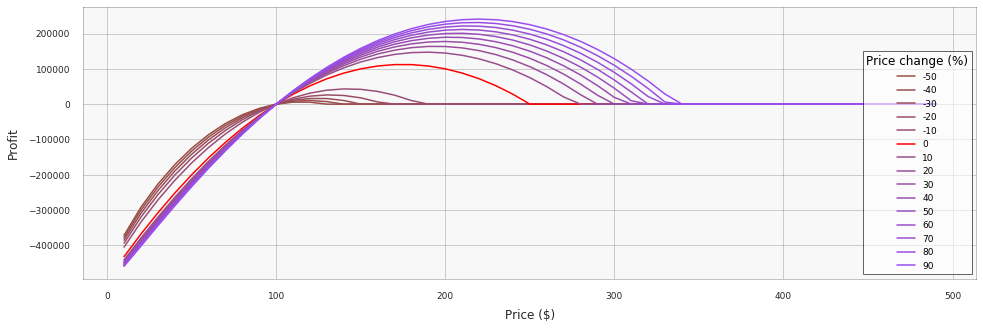

In [10]:
## Environment simulator
def plus(x):
  return 0 if x < 0 else x

def minus(x):
  return 0 if x > 0 else -x

def shock(x):
  #return 1 / (1 + np.exp(-x))
  #return np.log(x + 0.1)
  return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
  return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
  return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
  return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
  return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
  return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
  for j in range(len(price_change_grid)):
    profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
  if math.isclose(price_change_grid[i], 1.0):
    color = 'red'
  else:
    color = (0.6, 0.3, price_change_grid[i]/2.0)
  plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((price_change_grid-1)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)

In [11]:
# Find optimal constant price

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 170, achieved profit is 2352000.0


[170 490 220 190 180 170 490 220 190 180 170 490 220 190 180 170 490 220
 190 180]
Achieved profit is 2903637.2631194014


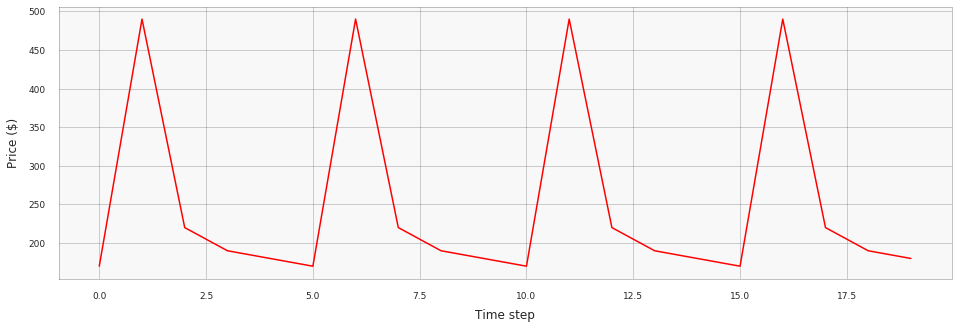

In [12]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
  p_grid = np.tile(p_baseline, (len(price_grid), 1))
  p_grid[:, t] = price_grid
  profit_grid = np.array([ profit_response(p) for p in p_grid ])
  return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
  price_t = find_optimal_price_t(p_opt, price_grid, t)
  p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.plot(range(len(p_opt)), p_opt, c='red')

# Visualization Functions

This section defines several auxillary visualization function used to visualize the results of the optimization, as well as some debuggin information.

In [0]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
  plt.figure(figsize=(16, 5))
  plt.xlabel("Episode")
  plt.ylabel("Return ($)")
  returns_df = pd.Series(returns)
  ma = returns_df.rolling(window=smoothing_window).mean()
  mstd = returns_df.rolling(window=smoothing_window).std()
  plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
  plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
  plt.figure(fig_number);
  plt.xlabel("Time step");
  plt.ylabel("Price ($)");
  plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
  return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

# Solution: Pricing Policy Optimization Using DQN
In this section, we develop a DQN-based optimizer of the pricing schedule using PyTorch.

Episod 980 of 1000 (98.00%)
Best profit results: 2539761.966296589
Best profit results: 2541645.183473097
Best profit results: 2550138.3571164305
Best profit results: 2551555.30228536
Best profit results: 2566501.8834681283
Best profit results: 2605363.9998276094
Best profit results: 2609818.990817896
Best profit results: 2612273.150380389
Best profit results: 2636522.040131117
Best profit results: 2652503.2733664988


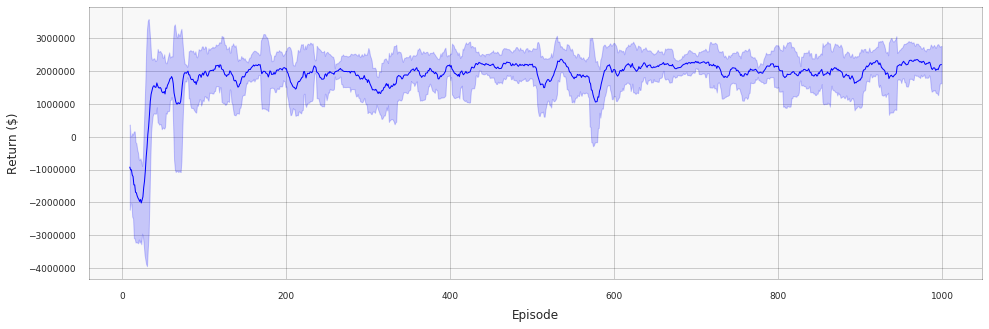

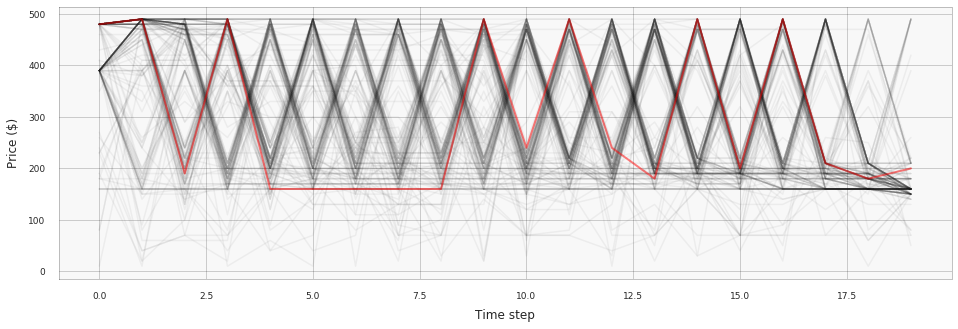

In [20]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
  
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class PolicyNetworkDQN(nn.Module):

    def __init__(self, state_size, action_size, hidden_size=128):
      super(PolicyNetworkDQN, self).__init__()
      layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
      ]
      self.model = nn.Sequential(*layers)

    def forward(self, x):
      pdparam = self.model(x)
      return pdparam  

class AnnealedEpsGreedyPolicy(object):
  def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
    self.eps_start = eps_start
    self.eps_end = eps_end
    self.eps_decay = eps_decay
    self.steps_done = 0

  def select_action(self, q_values):
    sample = random.random()
    eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
    self.steps_done += 1
    if sample > eps_threshold:
        return np.argmax(q_values)
    else:
        return random.randrange(len(q_values))

class BoltzmannQPolicy(object):
    def __init__(self, tau=0.5, clip=(-500., 500.)):
      self.tau = tau
      self.clip = clip

    def select_action(self, q_values):
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]
        exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
        probs = exp_values / np.sum(exp_values)
        action = np.random.choice(range(nb_actions), p=probs)
        return action

GAMMA = 1.00
TARGET_UPDATE = 20

def update_model(memory, policy_net, target_net):
    batch_size = 512
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_step(t, state, action):
  new_state = np.repeat(0, len(state))
  new_state[0] = price_grid[action]
  new_state[1:T] = state[0:T-1]
  new_state[T+t] = 1

  reward = profit_t_response(new_state[0], new_state[1])
  return new_state, reward

def to_tensor(x):
  return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
  return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = [] # price schedules used in each episod
for i_episode in range(num_episodes):
    state = np.repeat(0, 2*T)
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
          q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episod {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
  print(f'Best profit results: {profit}')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


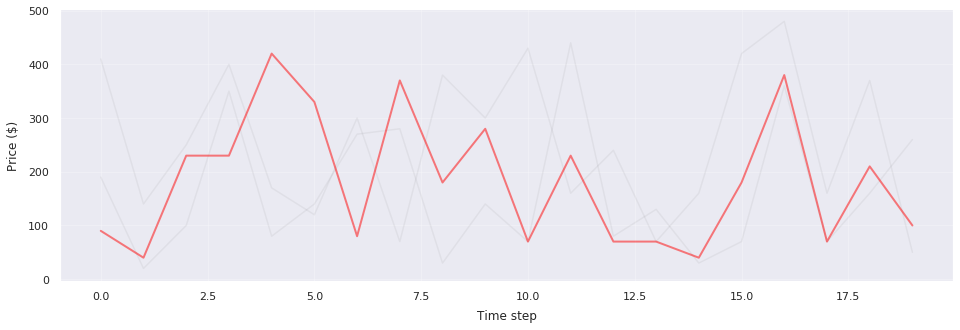

In [63]:
# Render and save the animation of the simulation process
!apt install imagemagick

plt.ioff()
fig = plt.figure(figsize=(16, 5))
def animate(t):
  fig.clear()
  plot_price_schedules(p_trace[0:t], 5, 1, fig.number)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(10, 100, 10), interval=50, blit=False, repeat_delay=500)
ani.save('sim.gif', dpi=80, writer='imagemagick', fps=20)
rc('animation', html='jshtml')
ani

Optimal price action 390


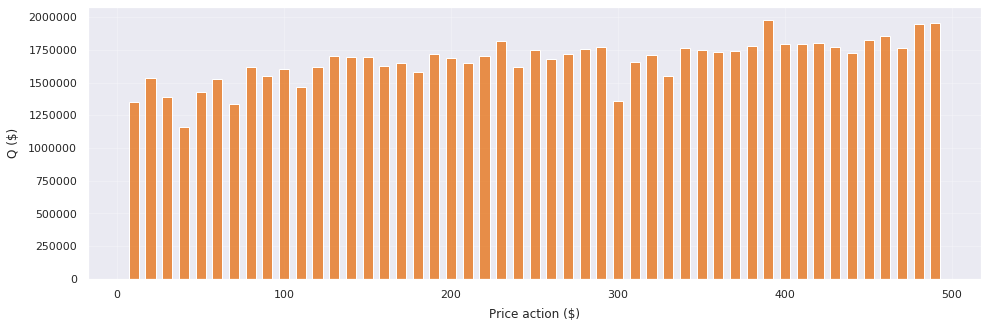

In [64]:
# Visualize Q values for a given state

sample_state = [170.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., \
                1.,     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]
Q_s = policy_net(to_tensor(sample_state))
a_opt = Q_s.max(0)[1].detach()
print(f'Optimal price action {price_grid[a_opt]}')

plt.figure(figsize=(16, 5))
plt.xlabel("Price action ($)")
plt.ylabel("Q ($)")
plt.bar(price_grid, Q_s.detach().numpy(), color=(0.9, 0.4, 0.0, 0.7),  width=6)
plt.show()

In [0]:
transitions = memory.sample(10)

In [82]:
batch = Transition(*zip(*transitions))

non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.stack(batch.reward)

state_action_values = policy_net(state_batch).gather(1, action_batch)

next_state_values = torch.zeros(len(transitions), device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch[:, 0]

##### 

q_trace = []
for t in range(len(transitions)):
  print(f"Q_(s,a)[ {expected_state_action_values[t]} ] = r [ {reward_batch[t].item()} ] + g*Q_(s+1)[ {next_state_values[t]} ]  <> Q_(s,a)[ {state_action_values[t].item()} ]")
  q_trace.append([f"Sample {t}", state_action_values[t].item(), [reward_batch[t].item(), next_state_values[t]]])

Q_(s,a)[ 1450870.75 ] = r [ 261736.65625 ] + g*Q_(s+1)[ 1189134.125 ]  <> Q_(s,a)[ 1495817.75 ]
Q_(s,a)[ 134832.8125 ] = r [ 134832.8125 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 132792.15625 ]
Q_(s,a)[ 377268.0625 ] = r [ 164921.0 ] + g*Q_(s+1)[ 212347.078125 ]  <> Q_(s,a)[ 359550.96875 ]
Q_(s,a)[ 2517715.75 ] = r [ 261245.15625 ] + g*Q_(s+1)[ 2256470.5 ]  <> Q_(s,a)[ 2645709.75 ]
Q_(s,a)[ 1558243.0 ] = r [ 0.0 ] + g*Q_(s+1)[ 1558243.0 ]  <> Q_(s,a)[ 1630786.25 ]
Q_(s,a)[ 1815145.5 ] = r [ 154475.796875 ] + g*Q_(s+1)[ 1660669.75 ]  <> Q_(s,a)[ 1704561.25 ]
Q_(s,a)[ 2782398.5 ] = r [ 0.0 ] + g*Q_(s+1)[ 2782398.5 ]  <> Q_(s,a)[ 2781231.5 ]
Q_(s,a)[ 2707601.0 ] = r [ 0.0 ] + g*Q_(s+1)[ 2707601.0 ]  <> Q_(s,a)[ 2770968.5 ]
Q_(s,a)[ 1738339.0 ] = r [ 0.0 ] + g*Q_(s+1)[ 1738339.0 ]  <> Q_(s,a)[ 1863343.0 ]
Q_(s,a)[ 2191904.5 ] = r [ 72000.0 ] + g*Q_(s+1)[ 2119904.5 ]  <> Q_(s,a)[ 2238972.5 ]


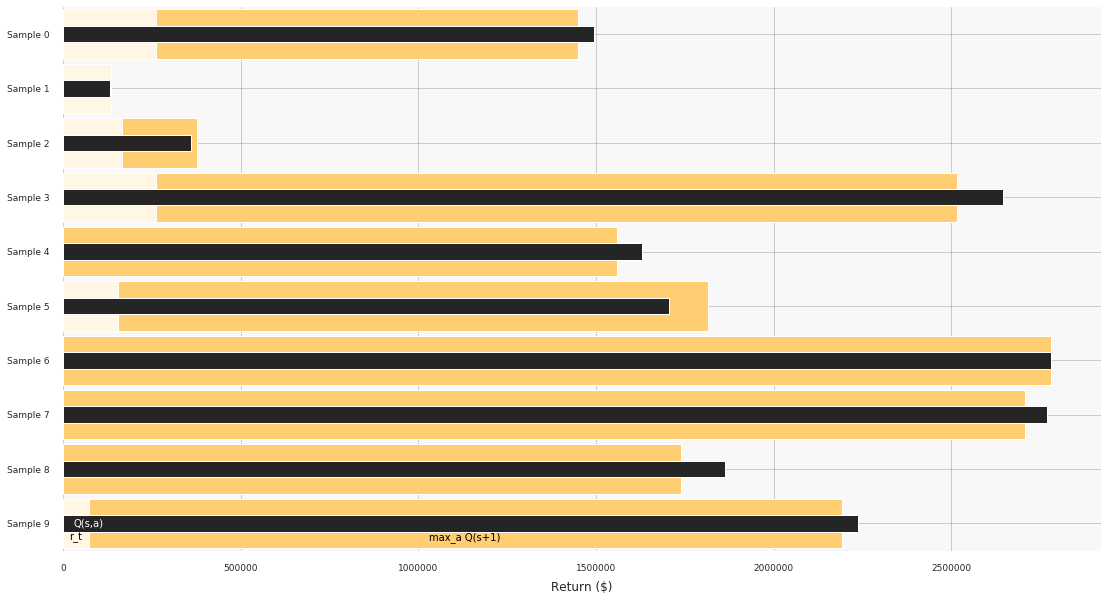

In [121]:
palette = sns.light_palette("orange", 3, reverse=False)
bullet_graph(np.array(q_trace),
            labels=["r_t", "max_a Q(s+1)"], bar_label="Q(s,a)", size=(20, 10),
            axis_label="Return ($)", label_color="black",
            bar_color="#252525", palette=palette)